In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from nltk.tokenize import TweetTokenizer
import time
from torch_scatter import scatter_max, scatter_mean, scatter_std
from sklearn.model_selection import KFold
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import spacy
import string
import os
import re
import math
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, DebertaV2Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModel.from_pretrained("microsoft/deberta-v3-large")

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

In [4]:

# all_vocab_str = []
# vector_keys = list(nlp.vocab.vectors.keys())
# for i in range(len(vector_keys)):
#     try:
#         t = nlp.vocab.strings[vector_keys[i]]
#         all_vocab_str.append(t)
#     except:
#         continue

In [5]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation
all_chars = set(allowed_chars)

In [6]:
with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
    
# embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(all_vocab_str, embeddings))
# del all_vocab_str
# del all_vocab_doc

In [7]:
with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)

128001

In [8]:
polarities_subjectivities.shape

torch.Size([128001, 2])

In [9]:
for i in range(len(all_vocab_str)):
    if 'nice' in all_vocab_str[i]:
        print(i, polarities_subjectivities[i])
        break

1085 tensor([0.7000, 0.6000], dtype=torch.float64)


In [10]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' \t'
all_chars = set(allowed_chars)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 224
folder_path = r'data\TextClassification\IMDB'
device

device(type='cuda')

In [12]:
train_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
train_df.head(2)

,label,text
0,1,I have seen this movie twice and it's theme is...
1,1,I happened to catch this on community TV a few...


In [13]:
keep_ratio = 1.0
test_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
test_df['Topic'] = test_df['label']
test_df['Content'] = test_df['text']
test_df.drop(['label', 'text'], axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.iloc[:int(keep_ratio*test_df.shape[0])]
train_df = pd.read_csv(r'data\TextClassification\IMDB\train.csv')
train_df['Topic'] = train_df['label']
train_df['Content'] = train_df['text']
train_df.drop(['label', 'text'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.iloc[:int(keep_ratio*train_df.shape[0])]
sst_classes = ["Negative", "Positive"]
df = pd.concat([train_df, test_df])
df.shape

(50000, 2)

In [14]:
doc_lengths = np.array([len(tx) for tx in df['Content'].values])
print(np.max(doc_lengths))

13704


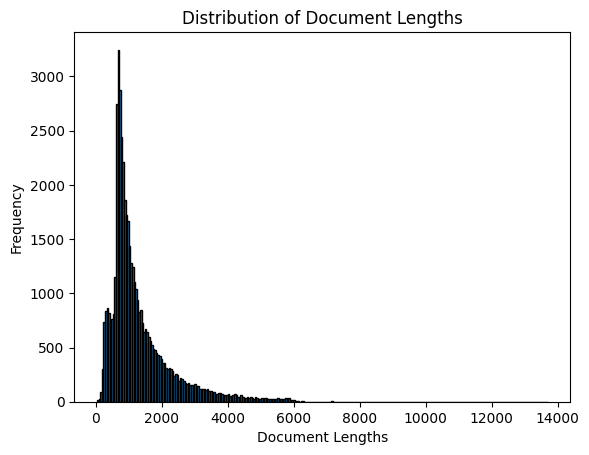

In [15]:
# Create a histogram
plt.hist(doc_lengths, bins='auto', edgecolor='black')
# plt.xlim([0,138000])
# Add labels and title
plt.xlabel('Document Lengths')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')

# Show the chart
plt.show()

In [16]:
class_list = df.Topic.unique()
class_id = {sst_classes[i]:i for i in class_list}
id_class = {i:sst_classes[i] for i in class_list}

In [17]:
char_set = set()
for doc in df.Content.values:
    char_set.update(set(' '.join(tokenizer.tokenize(doc))))
len(char_set)

197

In [18]:
# vocab_dict = {c:i for i, c in enumerate(allowed_chars)}
# if '\x01' not in vocab_dict:
#     vocab_dict['\x01'] = len(vocab_dict)
# char_Set = set(vocab_dict.keys())
# len(char_Set)

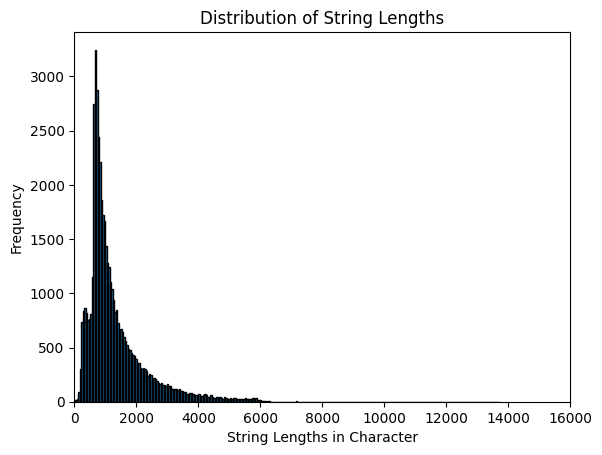

In [19]:
# Create a histogram
plt.hist(doc_lengths, bins='auto', edgecolor='black')
plt.xlim([0,16000])
# Add labels and title
plt.xlabel('String Lengths in Character')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')

# Show the chart
plt.show()

In [20]:
df['Content'].values[0]

"Steven what have you done you have hit an all new low. It is weird since Steven's last film shadow man was directed by the same director who did this trash. Shadow man was good this was diabolically bad so bad it wasn't even funny Steven is hardly in the movie and feels like he is in a cameo appearance and when he is in the film he is dubbed half the time anyway. As for the action well let's just say the wizard of oz had more action than this trash there is hardly any action in the film and when it does finally arrive it is boring depressing badly shot so called action scenes. Seagal hardly kills anyone unlike his over films where he goes one man army ie under siege 1 and 2 and exit wounds. the plot is so confusing with so many plot holes that it doesn't make scenes sometimes. flight of fury better be good what a shame i wasted 5 pounds on this garbage 0 out of ten better luck next time"

In [21]:
doc_token_lengths = np.array([len(tokenizer.tokenize(df['Content'].values[i])) for i in df.index])

In [22]:
np.max(doc_token_lengths)

2986

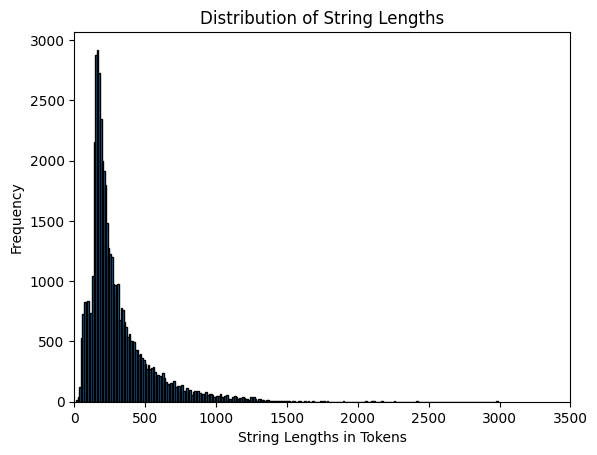

In [23]:
# Create a histogram
plt.hist(doc_token_lengths, bins='auto', edgecolor='black')
plt.xlim([0,3500])
# Add labels and title
plt.xlabel('String Lengths in Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')

# Show the chart
plt.show()

In [24]:
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(''.join(char_set).join(allowed_chars))
vocab_dict = {c:i for i, c in enumerate(all_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)
vocab_dict_rev = dict(zip(list(vocab_dict.values()), list(vocab_dict.keys())))

In [25]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, token_dict, sentiment_dict, tokenizer, shuffle=True, batch_size=128) -> None:
        super().__init__()
        # y = y[indices].values
        # y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        
        # print(f'self.num_sections1: {len(y) // batch_size}')
        
        if len(y) % batch_size != 0:
            self.shortage = ((len(y) // batch_size)+1)*batch_size - len(y)
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            
            # print(f'y1 - {y.shape}: {y}')
            y = np.concatenate([y, empty_labels])
            # print(f'y2 - {y.shape}: {y}')
            # print(f'X1 - {X.shape}: {X}')
            X = np.concatenate([X, empty_strings])
        #     print(f'X2 - {X.shape}: {X}')
        
        # print(f'self.num_sections2: {len(y) // batch_size}')
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.max_token_count = 0
        
        
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
            # tokens = [t.text for t in tokens]
            tokens = self.tokenizer(doc)
            if len(tokens) == 0:
                tokens = ['empty']
                            
            token_lengths = [len(t) for t in tokens]
            tokens.append('\x01')
            
            token_lengths.append(len(tokens[-1])-1)
            token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
            token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
            token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
            doc = ' '.join(tokens)
            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            token_positions = torch.arange(len(token_lengths), dtype=torch.long)
            token_indices = torch.repeat_interleave(token_positions, token_lengths)
            num_tokens = len(token_lengths)
            if num_tokens > self.max_token_count:
                self.max_token_count = num_tokens
            g_data = Data(x=characters,
                            token_positions=token_positions,
                            character_length = len(characters),
                            num_tokens = num_tokens,
                            token_indices=token_indices,
                            token_lengths=token_lengths,
                            token_embeddings=token_embs,
                            token_sentiments=token_sentiments)
            self.all_data.append(g_data)
        
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([self.all_data[i].character_length for i in range(len(self.all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        
    def __getitem__(self, index):
        index = self.get_section_index()
        return self.all_data[index], self.y[index]
        
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self):
        # if self.shuffle:
            
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = np.random.randint(t_range[0], t_range[1])
        # else:
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = t_range[0] + self.each_section_i[self.section_i]
        #     self.each_section_i[self.section_i] = (self.each_section_i[self.section_i] + 1) % (t_range[1] - t_range[0])
        # print()
        # print(f'self.section_i: {self.section_i},   self.position_j: {self.position_j}')
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
                # random_positions = np.random.choice(np.arange(0, self.section_size), size=self.section_size, replace=False)
        # return self.x_len_args[target_index]
        return target_index

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        # print(f'groups_size: {groups_size}')
        # print(f'len(len_sorted_args): {len(len_sorted_args)}')
        # print(f'k: {k}')
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            # print(f'candidate_indices: {candidate_indices}')
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
        
        # check_x = self.X[groups]
        # check_x_lens = [np.sum(np.array([len(sx) for sx in rx])) for rx in check_x]
        # print(f'check_x: {check_x}')
        
        
        return np.array(groups), groups_size
        

In [26]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [27]:
# def double_tokenizer(doc):
#     tokens = t_tokenizer.tokenize(doc)
#     tokens = nlp(' '.join(tokens))
#     tokens = [t.text for t in tokens]
#     return tokens

# def nlp_tokenizer(doc):
#     tokens = nlp(doc)
#     tokens = [t.text for t in tokens]
#     return tokens

In [28]:
tokens = tokenizer.tokenize(df.Content.values[0])

In [29]:
'have' in token_vocab_dict

True

In [30]:
[t for t in tokens if t not in token_vocab_dict]

[]

In [31]:
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, train_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, test_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

  0%|          | 35/25088 [00:00<07:54, 52.83it/s]

100%|██████████| 25088/25088 [05:56<00:00, 70.44it/s]


In [32]:
train_dataset[0]

(Data(x=[12420], token_positions=[2098], character_length=12420, num_tokens=2098, token_indices=[12420], token_lengths=[2098], token_embeddings=[2098, 64], token_sentiments=[2098, 2]),
 tensor([0., 1.]))

In [33]:
train_lengths = np.array([train_dataset[i][0].num_tokens for i in range(len(train_dataset))])
test_lengths = np.array([test_dataset[i][0].num_tokens for i in range(len(test_dataset))])
print(np.max(train_lengths))
print(np.max(test_lengths))

2987
3089


In [34]:
X, y = next(iter(test_dataloader))

In [35]:
test_dataset[0]

(Data(x=[6926], token_positions=[1192], character_length=6926, num_tokens=1192, token_indices=[6926], token_lengths=[1192], token_embeddings=[1192, 64], token_sentiments=[1192, 2]),
 tensor([0., 1.]))

In [36]:
for i in range(15,20):
    char_ids = X[i].x
    text_for_ids = ''.join([vocab_dict_rev[ci.item()] for ci in char_ids])
    print(torch.argmax(y[i]).item(), text_for_ids)

1 ▁[ CON TAIN S ▁SPOILER S ! ! ! ] < br ▁/ > < br ▁/ > ▁Garfield ▁and ▁his ▁owner ▁Jon ▁Arbuckle ▁were ▁in ▁a ▁rut . ▁They ▁basically ▁had ▁no ▁life ▁at ▁all . ▁All ▁they ▁did ▁was ▁lay ▁around ▁and ▁count ▁the ▁ceiling ▁tiles . ▁Jon ▁even ▁organized ▁his ▁sock ▁drawer ▁according ▁to ▁color ▁and ▁fabric . ▁He ▁needed ▁a ▁life . ▁So ▁he ▁consults ▁a ▁book ▁on ▁the ▁subject ▁that ▁tells ▁him ▁to ▁meet ▁a ▁woman . ▁A ▁singles ' ▁bar ▁was ▁a ▁great ▁place ▁to ▁start . ▁Unfortunately , ▁when ▁the ▁music ▁started ▁and ▁Jon ▁hit ▁the ▁dance ▁floor , ▁we ▁see ▁what ▁made ▁disco ▁die : ▁Jon ▁killed ▁it . ▁Jon ▁next ▁tried ▁to ▁pick ▁up ▁girls ▁at ▁the ▁video ▁store . ▁He ▁ended ▁up ▁feeling ▁down ▁in ▁the ▁mouth . ▁Literally . ▁The ▁laundromat ▁was ▁no ▁prize ▁either ▁when ▁Jon ▁and ▁his ▁would - be ▁date ▁get ▁a ▁glimpse ▁of ▁each ▁other ' s ▁underwear . ▁Jon ▁tried ▁to ▁act ▁all ▁buff ▁at ▁the ▁beach , ▁but ▁soon ▁he ▁angered ▁a ▁real ▁buff ▁guy , ▁which ▁left ▁Jon ▁feeling , ▁once ▁again , ▁

In [37]:
sample_rand = torch.randn((64, 1024))

In [38]:
sample_rand.var(unbiased=True)

tensor(0.9919)

In [39]:
X

DataBatch(x=[355681], token_positions=[66512], character_length=[224], num_tokens=[224], token_indices=[355681], token_lengths=[66512], token_embeddings=[66512, 64], token_sentiments=[66512, 2], batch=[355681], ptr=[225], cumulative_token_indices=[355681])

In [40]:
train_tensor = torch.randn((len(X.token_positions), 32))

In [41]:
torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens).shape

torch.Size([66512])

In [42]:
X.token_positions

tensor([ 0,  1,  2,  ..., 34, 35, 36])

In [43]:
train_tensor

tensor([[ 0.2902, -1.5769,  0.0973,  ...,  0.8986,  0.8537, -0.8959],
        [-0.5405, -0.2818,  0.9853,  ...,  1.1739, -0.7419, -1.6283],
        [-0.4099, -0.3418,  2.2702,  ..., -0.3704,  0.2404, -1.3291],
        ...,
        [ 1.9172,  0.8530,  0.7340,  ..., -1.0294,  1.9511,  0.2843],
        [-1.1761,  0.5010,  0.2658,  ...,  0.1410,  0.5511,  0.6099],
        [-2.1716, -1.0277,  0.4055,  ...,  0.9374, -0.8740, -0.1705]])

In [44]:
from torch_geometric.nn import GATv2Conv, SimpleConv

# Normalization on each feature of all tokens, for this we used batch norm class but with tokens at batch dimention
class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights

In [45]:
# from copy import copy, deepcopy
# gcnn_model = GCNN(64)
# flopt_counter = FlopCounterMode(gcnn_model)
# X.edge_index = torch.randint(0, len(X.token_positions), size=(2,200))
# with flopt_counter:
#     x_input = deepcopy(torch.randn((len(X.token_positions), 64)))
#     edge_data = deepcopy(X.edge_index)
#     gcnn_model(x_input, edge_data)

In [46]:
# sample_t = torch.randn((400, 5))
# sample_t.shape
# print(torch.mean(sample_t, dim=0))
# print(torch.std(sample_t, dim=0))
# bn1 = nn.BatchNorm1d(5)
# print(torch.mean(bn1(sample_t), dim=0).detach())
# print(torch.std(bn1(sample_t), dim=0).detach())

In [47]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2, seed=-1):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance, seed=-1):
        if seed>-1:
            torch.manual_seed(seed)
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [48]:
class Sentiment_Injection(nn.Module):
    
    def __init__(self, hidden_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.conv1 = nn.Conv1d(2, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, token_sentiments):
        x1 = F.relu_(self.bn1(self.conv1(token_sentiments.T).T))
        x = F.relu_(self.conv2(torch.cat([x, x1], dim=1).T))
        # x = x + x1
        return x.T

In [49]:
# sentiment1  = Sentiment_Injection(64)
# sentiment1(torch.ones((41047, 64)), torch.ones((41047, 2))).shape

In [50]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, use_positional_encoder=[False, False, False], *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        # self.use_token_polarity = use_token_polarity
        self.use_positional_encoder = use_positional_encoder
        if seed>-1:
            torch.manual_seed(seed)
 
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        
        if True in use_positional_encoder:
            self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
            self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        # if self.use_token_polarity[0]:
        #     self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        # else:
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        # if self.use_token_polarity[1]:
        self.sentiment1  = Sentiment_Injection(hidden_dim)
        # if self.use_token_polarity[2]:
        self.sentiment2  = Sentiment_Injection(hidden_dim)
            
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 4
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
        self.max_length = 0
    
    def forward(self, g_data):
            
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        # if self.use_token_polarity[0]:
        #     x = torch.cat([x1, x2, g_data.token_sentiments.T], dim=0)
        # else:
        x = torch.cat([x1, x2], dim=0)
            
        x = F.relu(self.conv3(x)).T
        
        if self.use_positional_encoder[0]:
            x = x + self.positional_encoding(g_data.token_positions)
            
        # if self.use_token_polarity[1]:
        x = self.sentiment1(x, g_data.token_sentiments)
        
            
        # x = x + self.positional_encoding(g_data.token_positions)

        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x, edge_weights = self.gcnn1(graph.x, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        
        # if self.use_token_polarity[2]:
        x = self.sentiment2(x, g_data.token_sentiments)
            
        
        if self.use_positional_encoder[1]:
            xa = graph.x[:g_data.token_embeddings.shape[0]] + self.positional_encoding(g_data.token_positions)
        else:
            xa = graph.x[:g_data.token_embeddings.shape[0]]
        if self.use_positional_encoder[2]:
            xb = g_data.token_embeddings + self.positional_encoding(g_data.token_positions)
        else:
            xb = g_data.token_embeddings
        x = torch.cat([xa, xb], dim=1)
        # x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]], g_data.token_embeddings], dim=1)
        
        x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        x, edge_weights = self.gcnn2(x, graph.edge_index)

        x = F.elu_(self.fc1(x))
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


    def create_positional_encoding(self):
        position = torch.arange(self.pos_emb_size).unsqueeze(1)
        # div_term = self.pos_emb_size ** (torch.arange(0, 64, 2)/64.0)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)

In [51]:
# # for p1 in [False, True]:
# #     for p2 in [False, True]:
# #         for p3 in [False, True]:
# # print(f'\n{p1}, {p2}, {p3}: \n')
# classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3200, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_positional_encoder=[True, False, False]).eval()
# flopt_counter = FlopCounterMode(classifier_torch_model)
# with flopt_counter:
#     classifier_torch_model(X)


In [52]:
# # for p1 in [False, True]:
# #     for p2 in [False, True]:
# #         for p3 in [False, True]:
# # print(f'\n{p1}, {p2}, {p3}: \n')
# classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3200, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_positional_encoder=[False, False, False]).eval()
# flopt_counter = FlopCounterMode(classifier_torch_model)
# with flopt_counter:
#     classifier_torch_model(X)


In [53]:
# next(iter(classifier_torch_model.parameters())).device

In [54]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [55]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [56]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager=None, train_dataloaders=None, val_dataloaders=None, datamodule=None, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders, min_lr=min_lr,max_lr=max_lr, num_training=150)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [57]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        # if(give_hinge_loss):
        #     print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                # if(give_hinge_loss):
                #     print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [58]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [59]:
# output_size = 32
# hidden_dim = 16
# embedding_dim = 16
# label_size = 1
# seed = 911

In [60]:
# for i in range(10):
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True, use_positional_encoder=[False, True, True]):
    torch.autograd.set_detect_anomaly(True)
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3200, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_positional_encoder=use_positional_encoder).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name=f'CNN-GNN_{use_positional_encoder[0]}_{use_positional_encoder[1]}_{use_positional_encoder[2]}',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [59]:
torch.cuda.empty_cache()
import gc
gc.collect()

40

In [62]:
len(test_dataset)

25088

In [63]:
# positions = []
# j = 0
# for i in range(len(test_dataset)):
#     # if i% 1000 ==0:
#     #     print(j)
#     X, y = test_dataset[i]
#     positions.append(len(X.token_positions))
# positions = np.array(positions)
# positions.max()

In [64]:
# model_manager = train_model(1, 0.2, 0.000012, 0.0032, fused=False, use_positional_encoder=[False, False, False])


In [60]:
for _ in [[True, False, False]]:
    for j in range(3):
        model_manager = train_model(70, 0.2, 0.000012, 0.0032, fused=False, use_positional_encoder=[_[0], _[1], _[2]])
        time.sleep(20)
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        time.sleep(20)

NameError: name 'train_model' is not defined

In [61]:
# for _ in [[False, False, False]]:
#     for j in range(3):
#         model_manager = train_model(70, 0.2, 0.000012, 0.0032, fused=False, use_positional_encoder=[_[0], _[1], _[2]])
#         time.sleep(20)
#         torch.cuda.empty_cache()
#         import gc
#         gc.collect()
#         time.sleep(20)

In [62]:
def calculatge_metrics(chpt_path, target_data_loader, use_positional_encoder=[False, False, False]):    
        classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=3200, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_positional_encoder=use_positional_encoder)
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in target_data_loader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec

In [63]:
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [64]:
def calculate_average_metrics_mean(base_path = 'logs\CNN-GNN18_mr2k_seeds', use_positional_encoder=[False, False, False]):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []

    for k_fold_num in range(1):
        infer_acc, infer_f1, infer_prec, infer_rec, infer_loss = [], [], [], [], []
        for j in range(3):
            # i = k_fold_num*3 + j
            # k_fold_num = i//3
            # test_dataset.set_active_fold(k_fold_num)
            # test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
            
            version_path = join(base_path, f'version_{j}')
            checkpoint_path = join(version_path, f'checkpoints')
            onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
            epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
            best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
            print(onlyfiles[best_chpt_id])
            mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, use_positional_encoder=use_positional_encoder)
                
            infer_acc.append(mean_infer_acc)
            infer_f1.append(mean_infer_f1)
            infer_prec.append(mean_infer_prec)
            infer_rec.append(mean_infer_rec)
            infer_loss.append(loss)

        total_accuracy.append(torch.mean(torch.tensor(infer_acc)))
        total_f1.append(torch.mean(torch.tensor(infer_f1)))
        total_prec.append(torch.mean(torch.tensor(infer_prec)))
        total_rec.append(torch.mean(torch.tensor(infer_rec)))
        total_loss.append(torch.mean(torch.tensor(infer_loss)))

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')

In [65]:
def calculate_average_metrics_max(base_path = 'logs\CNN-GNN18_mr2k_seeds', use_positional_encoder=[False, False, False]):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []

    for k_fold_num in range(10):
        infer_acc, infer_f1, infer_prec, infer_rec, infer_loss = [], [], [], [], []
        for j in range(3):
            i = k_fold_num*3 + j
            # k_fold_num = i//3
            test_dataset.set_active_fold(k_fold_num)
            test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
            
            version_path = join(base_path, f'version_{i}')
            checkpoint_path = join(version_path, f'checkpoints')
            onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
            epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
            best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
            print(onlyfiles[best_chpt_id])
            mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, use_positional_encoder=use_positional_encoder)
                
            infer_acc.append(mean_infer_acc)
            infer_f1.append(mean_infer_f1)
            infer_prec.append(mean_infer_prec)
            infer_rec.append(mean_infer_rec)
            infer_loss.append(loss)

        total_accuracy.append(torch.max(torch.tensor(infer_acc)))
        total_f1.append(torch.max(torch.tensor(infer_f1)))
        total_prec.append(torch.max(torch.tensor(infer_prec)))
        total_rec.append(torch.max(torch.tensor(infer_rec)))
        total_loss.append(torch.min(torch.tensor(infer_loss)))

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')

In [66]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_True_True_True', [True, True, True])

In [67]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_True_True_False', [True, True, False])

In [68]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_True_False_True', [True, False, True])

In [71]:
calculate_average_metrics_mean(r'logs\CNN-GNN_True_False_False', [True, False, False])

epoch=49-step=5600.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=24-step=2800.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=40-step=4592.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
C:\Users\fardin\AppData\Local\Temp\ipykernel_1576\1074748613.py:22: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
C:\Users\fardin\AppData\Local\Temp\ipykernel_1576\1074748613.py:22: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
C:\Users\fardin\AppData\Local\Temp\ipykernel_1576\

total_accuracy: 0.5245588860544218
total_f1: nan
total_prec: nan
total_rec: 0.5245494198642423
total_loss: 0.30885953704516095


C:\Users\fardin\AppData\Local\Temp\ipykernel_1576\1074748613.py:22: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))


In [83]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_False_True_True', [False, True, True])

In [84]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_False_True_False', [False, True, False])

In [85]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_True', [False, False, True])

In [86]:
calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_False', [False, False, False])

epoch=21-step=2464.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=21-step=2464.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


epoch=22-step=2576.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


total_accuracy: 0.9092155612244898
total_f1: 0.909334022870215
total_prec: 0.9094525515881827
total_rec: 0.9092155612244898
total_loss: 0.25597233573595685


In [6]:
acc = (0.9080835459183674 + 0.9083227040816326 + 0.908203125)/3.0
prec = ((0.90932352+0.90685106)/2 + (0.91167015+0.90502926)/2 + (0.91444759 + 0.90214404)/2) / 3
recal = ((0.90656888+0.90959821)/2 +(0.90425702+0.91238839)/2+ (0.90066964+0.91573661)/2)/3
f1 = 2*prec*recal/(prec+recal)
loss = (0.3364 + 0.2623 + 0.3279)/3
acc, prec, recal, f1, loss

(0.908203125, 0.90824427, 0.908203125, 0.908223697034005, 0.3088666666666667)

In [ ]:
p=85.78
r=86.06
2*p*r/(p+r)

85.91977188081937